# Generate Simulated Observation Data for KN
- Input data for SED classifier
- Author: Gregory S.H. Paek (23.5.11)

In [26]:
from astropy.time import Time

# Setting

In [1]:
import pickle

with open('../model/gw170817-like.interp.pkl', 'rb') as f:
	interp = pickle.load(f)

- Kilonova Parameters

In [2]:
import numpy as np

#	Ejecta mass, velocity
mdarr = np.array([0.001, 0.003, 0.01, 0.03, 0.1])
vdarr = np.array([0.05, 0.15, 0.3])
mwarr = np.array([0.001, 0.003, 0.01, 0.03, 0.1])
vwarr = np.array([0.05, 0.15, 0.3])
#	Viewing angle
angarr = np.linspace(0, 180, 54)

#	min-max (1002.35-127,695.0 AA)
lamarr = np.arange(1003, 127695.+1, 1)

# Single Case

In [3]:
point = (
	mdarr[0],
	vdarr[0],
	mwarr[0],
	vwarr[0],
	angarr[0],
	1,
	lamarr,
)

iflux = interp(point)

(3750.0, 9000.0)

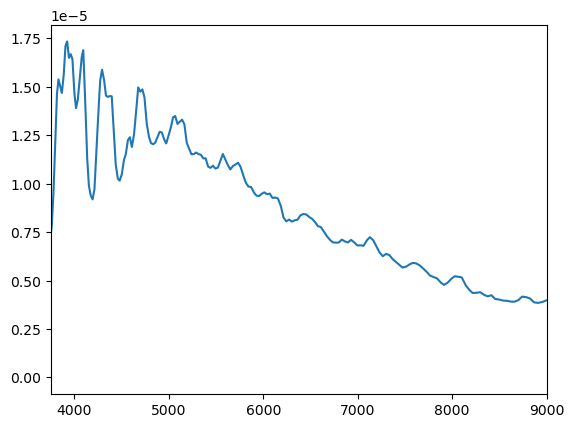

In [4]:
import matplotlib.pyplot as plt
plt.plot(lamarr, iflux)
plt.xlim(3750, 9000)

In [5]:
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *

In [6]:
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [7]:
filterset = [f"{group}-{filte}" for filte, _, group in filterlist_med25nm]
bands = speclite.filters.load_filters(*filterset)

In [8]:
mags = bands.get_ab_magnitudes(*bands.pad_spectrum(iflux, lamarr)).to_pandas().to_numpy()[0]

In [9]:
fnuarr = (mags*u.ABmag).to(u.uJy)
flamarr = convert_fnu2flam(fnuarr, bands.effective_wavelengths)

(3750.0, 9000.0)

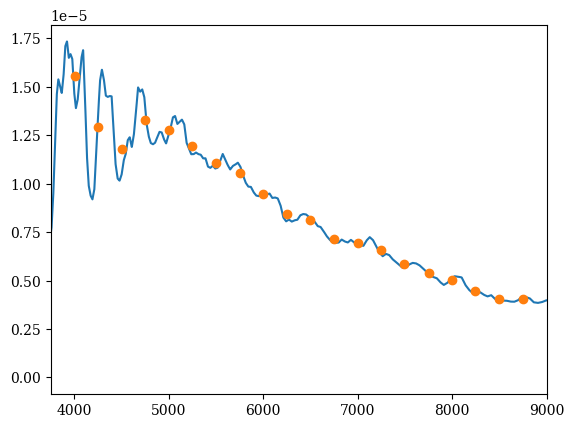

In [10]:
plt.plot(lamarr, iflux)
plt.plot(bands.effective_wavelengths, flamarr, 'o')
plt.xlim(3750, 9000)

# Iteration for generating the simulated observation data

In [11]:
# 필요한 라이브러리 불러오기
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# 거리 정의 (Mpc)
distances = [40, 156] * u.Mpc

# 각 거리에 대한 적색 이동 계산
redshifts = [z_at_value(cosmo.luminosity_distance, d) for d in distances]

# 결과 출력
for i, d in enumerate(distances):
    print(f"The redshift for a distance of {d} is {redshifts[i]:.3f}")

d = 40*1e6 # [pc]
redshift = redshifts[0]


The redshift for a distance of 40.0 Mpc is 0.009 redshift
The redshift for a distance of 156.0 Mpc is 0.035 redshift


In [24]:
typ = 'kn'
exptime = 180
distance_Mpc = int(d/1e6) # [Mpc]
group = 'med25nm'

path_save = f'../input/{typ}/{distance_Mpc:0>3}Mpc/{exptime:0>3}s/{group}'

if not os.path.exists(path_save):
    os.makedirs(path_save)

## Declare the 7DT Class

In [13]:
#	Subsequent filter info [AA]
bandmin=4000
bandmax=9000
bandwidth=250
bandstep=250
#	Maximum transmission of each filters
bandrsp=0.95
#	Wavelength bin [AA]
lammin=1000
lammax=10000
lamres=1000
#	Exposure Time [s]
# exptime = 60
exptime = 180
# exptime = 300

- medium band (bandwidth=25nm)

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


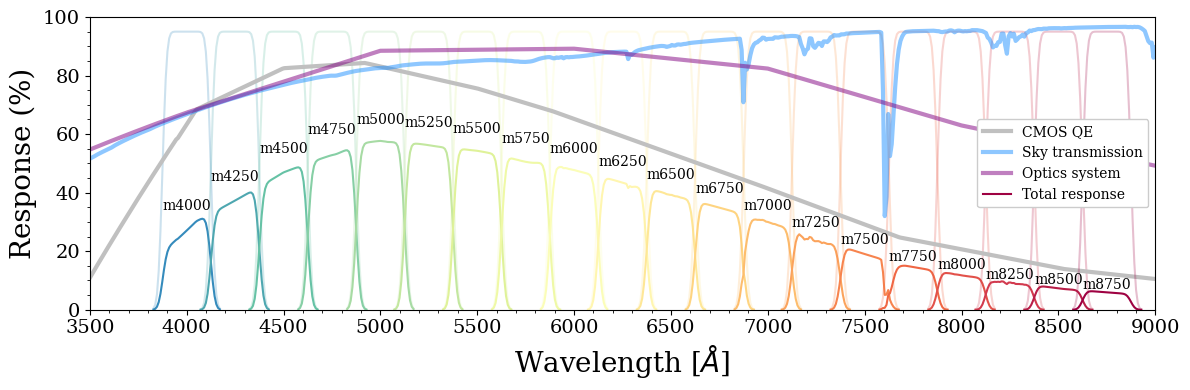

In [14]:
sdt = SevenDT()
sdt.echo_optics()
filterset = sdt.generate_filterset(bandmin=bandmin, bandmax=bandmax, bandwidth=bandwidth, bandstep=bandstep, bandrsp=bandrsp, lammin=lammin, lammax=lammax, lamres=lamres)
# sdt.plot_filterset()
T_qe = sdt.get_CMOS_IMX455_QE()
# T_comp = sdt.get_CCD_Hamamtsu_QE()
# sdt.plot_QE()
sdt.get_optics()
s = sdt.get_sky()
# sdt.plot_sky()
sdt.smooth_sky()
# sdt.plot_sky_smooth()
# sdt.plot_sky_sb()
totrsptbl = sdt.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt.get_phot_aperture(exptime=exptime, fwhm_seeing=1.5, optfactor=0.6731, verbose=False)
outbl = sdt.get_depth_table(Nsigma=5)
# sdt.plot_point_source_depth()
sdt.get_speclite()

- broad-band

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


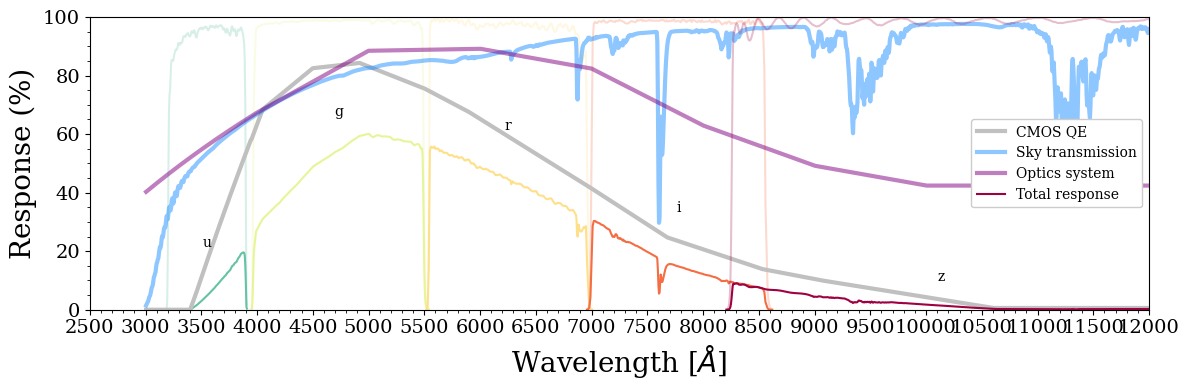

In [49]:
sdt_broad = SevenDT()
sdt_broad.echo_optics()
filterset_broad = sdt_broad.get_sdss_filterset()
# sdt_broad.plot_filterset()
T_qe = sdt_broad.get_CMOS_IMX455_QE()
# T_comp = sdt_broad.get_CCD_Hamamtsu_QE()
# sdt_broad.plot_QE()
sdt_broad.get_optics()
s = sdt_broad.get_sky()
# sdt_broad.plot_sky()
sdt_broad.smooth_sky()
# sdt_broad.plot_sky_smooth()
# sdt_broad.plot_sky_sb()
totrsptbl = sdt_broad.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt_broad.get_phot_aperture(exptime=exptime, fwhm_seeing=1.5, optfactor=0.6731, verbose=False)
outbl = sdt_broad.get_depth_table(Nsigma=5)
# sdt_broad.plot_point_source_depth()
sdt_broad.get_speclite()

## Iteration

In [40]:
phasearr = np.array([0.125, 0.25, 0.5, 1.0])
angarr = np.array([0, 30, 60, 90])
total_number = len(mdarr) * len(vdarr) * len(mwarr) * len(vwarr) * len(angarr) * len(phasearr)
print("Number of parameters:", len(mdarr), len(vdarr), len(mwarr), len(vwarr), len(angarr), len(phasearr))
print("Total Number of parameters:", total_number)

Number of parameters: 5 3 5 3 4 4
Total Number of parameters: 3600


In [50]:
# len(phasearr), len(mdarr), len(vdarr), len(mwarr), len(vwarr), len(angarr)
import itertools
for cc, combination in enumerate(itertools.product(mdarr, vdarr, mwarr, vwarr, angarr, phasearr)):
    print(f"[{cc+1:0>4}/{total_number}]", end='\r')
    # print(combination)
    prefix = f"obs.{cc:0>6}"
    #
    md, vd, mw, vw, ang, phase = combination
    #
    point = (*combination, lamarr)
    #	Interpolated flux (but luminosity!)
    iflux = interp(point)
    ifnu = convert_flam2fnu(iflux*flamunit, lamarr*lamunit)
    absmag = ifnu.to(u.ABmag)-2.5*np.log10(54)*u.ABmag
    appmag = convert_abs2app(absmag.value, d=40*1e6)

    #	Distance Scaled flux
    fnu = (appmag*u.ABmag).to(u.uJy)
    flam = convert_fnu2flam(fnu, lamarr*lamunit)

    #   Medium-band
    _, __ = sdt.get_phot_aperture(exptime=exptime, fwhm_seeing=1.5, optfactor=0.6731, verbose=False)
    _ = sdt.get_depth_table(Nsigma=5)
    obstbl = sdt.get_synphot2obs(flam, lamarr*lamunit, z=None, z0=redshift, figure=True)

    #	Meta data
    obstbl['md'] = md
    obstbl['vd'] = vd
    obstbl['mw'] = mw
    obstbl['vw'] = vw
    obstbl['ang'] = ang
    obstbl['phase'] = phase
    obstbl['type'] = typ
    obstbl['group'] = group
    obstbl['exptime'] = exptime
    obstbl['redshift'] = redshift.value
    obstbl['dist'] = d
    obstbl['author'] = 'G.Paek'
    obstbl['date'] = Time.now().isot
    obstbl.write(f"{path_save}/{prefix}.fits", overwrite=True)

    plt.title(f"md:{md:.3} vd:{vd:.3} mw:{mw:.3} vw:{vw:.3} ang:{ang:g} phase:{phase:.3}")
    plt.tight_layout()
    plt.savefig(f"{path_save}/{prefix}.png", dpi=100)
    plt.close('all')

    # if cc == 10: break

print("Done!")

Done!/3600]


## Broad-band

In [51]:
typ = 'kn'
exptime = 180
distance_Mpc = int(d/1e6) # [Mpc]
group = 'broad'

path_save = f'../input/{typ}/{distance_Mpc:0>3}Mpc/{exptime:0>3}s/{group}'

if not os.path.exists(path_save):
    os.makedirs(path_save)

In [52]:
# len(phasearr), len(mdarr), len(vdarr), len(mwarr), len(vwarr), len(angarr)
import itertools
for cc, combination in enumerate(itertools.product(mdarr, vdarr, mwarr, vwarr, angarr, phasearr)):
    print(f"[{cc+1:0>4}/{total_number}]", end='\r')
    # print(combination)
    prefix = f"obs.{cc:0>6}"
    #
    md, vd, mw, vw, ang, phase = combination
    #
    point = (*combination, lamarr)
    #	Interpolated flux (but luminosity!)
    iflux = interp(point)
    ifnu = convert_flam2fnu(iflux*flamunit, lamarr*lamunit)
    absmag = ifnu.to(u.ABmag)-2.5*np.log10(54)*u.ABmag
    appmag = convert_abs2app(absmag.value, d=40*1e6)

    #	Distance Scaled flux
    fnu = (appmag*u.ABmag).to(u.uJy)
    flam = convert_fnu2flam(fnu, lamarr*lamunit)

    #   Medium-band
    _, __ = sdt_broad.get_phot_aperture(exptime=exptime, fwhm_seeing=1.5, optfactor=0.6731, verbose=False)
    _ = sdt_broad.get_depth_table(Nsigma=5)
    obstbl = sdt_broad.get_synphot2obs(flam, lamarr*lamunit, z=None, z0=redshift, figure=True)

    #	Meta data
    obstbl['md'] = md
    obstbl['vd'] = vd
    obstbl['mw'] = mw
    obstbl['vw'] = vw
    obstbl['ang'] = ang
    obstbl['phase'] = phase
    obstbl['type'] = typ
    obstbl['group'] = group
    obstbl['exptime'] = exptime
    obstbl['redshift'] = redshift.value
    obstbl['dist'] = d
    obstbl['author'] = 'G.Paek'
    obstbl['date'] = Time.now().isot
    obstbl.write(f"{path_save}/{prefix}.fits", overwrite=True)

    plt.title(f"md:{md:.3} vd:{vd:.3} mw:{mw:.3} vw:{vw:.3} ang:{ang:g} phase:{phase:.3}")
    plt.tight_layout()
    plt.savefig(f"{path_save}/{prefix}.png", dpi=100)
    plt.close('all')

    # if cc == 10: break

print("Done!")

KeyboardInterrupt: 